In [47]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
from statistics import mean, stdev

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 

# Load TCP/UDP Benign and Malicious CIC2023 Flows

In [75]:
# Acquire Data
# Data here has all features
current_path = os.getcwd()

# BENIGN DATA FILES ***************************************
file1='dataset/Benign.csv'
benign = pd.read_csv(file1)
benign['attack'] = 0

# DDOS-VOLUMETRIC ATTACK ***********************************
file2='dataset/TCPFlood.csv'
file3='dataset/UDPFlood.csv'
udp = pd.read_csv(file2)
tcp = pd.read_csv(file3)
udp['attack'] = 1
tcp['attack'] = 1

# DDOS-TRANSPORT PROTOCOL VULNERABILITIES *******************
file4='dataset/ACKFrag.csv'
file5='dataset/SYN.csv'
file6='dataset/RSTFIN.csv'
file7='dataset/PUSHACK.csv'
file8='dataset/UDPFrag.csv'

ack = pd.read_csv(file4)
syn = pd.read_csv(file5)
rst = pd.read_csv(file6)
psh = pd.read_csv(file7)
udp_frag = pd.read_csv(file8)

ack['attack'] = 1
syn['attack'] = 1
rst['attack'] = 1
psh['attack'] = 1
udp_frag['attack'] = 1

# DDOS-APPLICATION PROTOCOL VULNERABILITIES *******************
file91='dataset/HTTPFlood.csv'
file92='dataset/Slowloris.csv'
http = pd.read_csv(file91)
slow = pd.read_csv(file92)
http['attack'] = 1
slow['attack'] = 1
## CONCATE ALL THE RECORDS ************************************
frames = [benign, 
          tcp, udp,
          syn, rst, ack, psh, 
          udp_frag,
          http, slow]

data = pd.concat(frames)
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)

In [76]:
# Size of the data
print("Shape of data: ", data.shape)
# Attack wise size
print("Attack and Benign Records: ", data["attack"].value_counts())

Shape of data:  (388251, 35)
Attack and Benign Records:  attack
1    292282
0     95969
Name: count, dtype: int64


In [77]:
data.columns

Index(['ts', 'srcip', 'dstip', 'srcport', 'dstport', 'proto_type', 'sbytes',
       'dbytes', 'flow_bytes', 'rate', 'srate', 'drate', 'spkts', 'dpkts',
       'ttl', 'iat', 'max_iat', 'min_iat', 'total_duration',
       'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len', 'state_con',
       'state_int', 'state_rst', 'fin_flag_number', 'syn_flag_number',
       'psh_flag_number', 'ack_flag_number', 'urg_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'attack', 'x', 'type'],
      dtype='object')

# Select parameters based on the model i.e. with or without time based features

In [78]:
# Features according to Importance
features =['flow_bytes','srate','drate', 'type',
        'ttl','max_iat',
        'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len',
        'state_con','state_int', 'state_rst', 
        'fin_flag_number', 'syn_flag_number',
        'psh_flag_number', 'ack_flag_number', 
        #'urg_flag_number','ece_flag_number', 
        #'cwr_flag_number'
          ]
best_features = data[features] 
target_features = data[['attack']]

# Split Dataset into X and Y

In [79]:
# Split of  predictors and response variable
X= best_features
y= target_features

# Use StratifiedKFold with K=10

In [80]:
# Create  classifier object.
rf = RandomForestClassifier(n_estimators = 1, n_jobs=2, random_state=0, max_depth=10)  
n_splits = 10
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
accu_stratified = []
conf_matrices = []  # Store confusion matrices
per_class_accuracies = [] 

In [81]:
# Create model with StratifiedKFold   
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    #accu_stratified.append(rf.score(x_test_fold, y_test_fold))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_fold,rf.predict(x_test_fold))
    conf_matrices.append(conf_matrix)
    
    # Compute per-class accuracies
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    per_class_accuracies.append(per_class_accuracy)

# Convert lists to numpy arrays for easier manipulation
conf_matrices = np.array(conf_matrices)
per_class_accuracies = np.array(per_class_accuracies)


/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_23711/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_23711/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_23711/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_23711/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

Accuracy of Attack Records:  [0.96967802 0.94904658 0.9863499  0.96957383 0.97718037 0.96290507
 0.97811816 0.97592998 0.97947275 0.98395165]

Median Accuracy of Attack Records: 97.65551734917162 %

Standard Deviation of Attack Records: 0.011006423277625793
Accuracy of Benign Records:  [0.96705327 0.95788285 0.94874778 0.96866019 0.96934446 0.96681265
 0.97327905 0.95374299 0.95887505 0.94163331]

Median Accuracy of Benign Records: 96.28438483645819 %

Standard Deviation of Benign Records: 0.010219913196943221


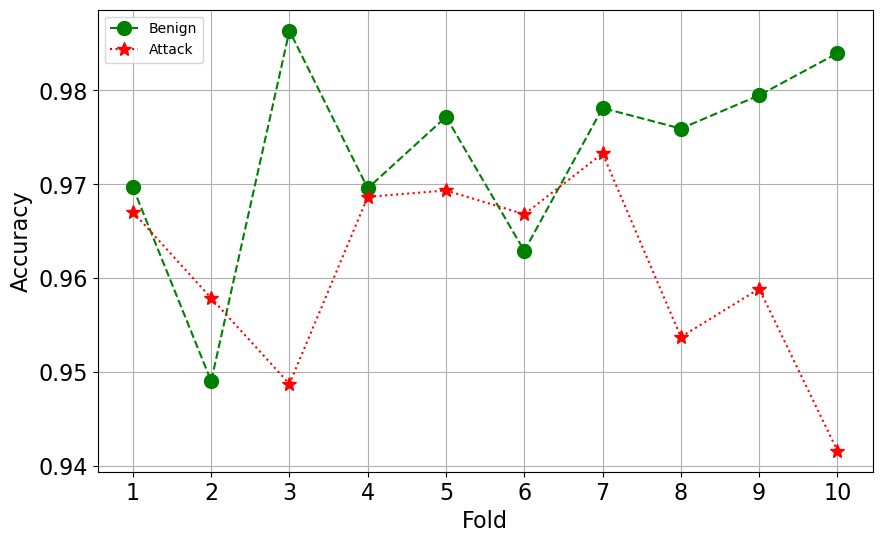

In [82]:
# Plotting per-class accuracies

plt.figure(figsize=(10, 6))
for i, class_accuracy in enumerate(per_class_accuracies.T, 1):
    if(i==1):
        plt.plot(range(1, n_splits + 1), class_accuracy, marker='o', label=f'Benign', color='green',  linestyle='dashed', markersize=10)
        print("Accuracy of Attack Records: ", class_accuracy)
        print('\nMedian Accuracy of Attack Records:', np.median(class_accuracy)*100, '%')
        print('\nStandard Deviation of Attack Records:', stdev(class_accuracy))
    else:
        plt.plot(range(1, n_splits + 1), class_accuracy, marker='*', label=f'Attack', color='red',  linestyle='dotted', markersize=10)  
        print("Accuracy of Benign Records: ", class_accuracy)
        print('\nMedian Accuracy of Benign Records:', np.median(class_accuracy)*100, '%')
        print('\nStandard Deviation of Benign Records:', stdev(class_accuracy))
    
plt.title('')
plt.xlabel('Fold', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(range(1, n_splits + 1))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.legend()
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('StratifiedKFold_5Tree.png', bbox_inches='tight')
plt.show()

# Training model on the whole dataset

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(n_estimators = 1, n_jobs=2, random_state=0, max_depth=10)
rf.fit(X, y)

/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_23711/233669711.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


RandomForestClassifier(max_depth=10, n_estimators=1, n_jobs=2, random_state=0)

# Mean Decrease of Accuracy of the Parameters

[0.3721962602027483, 0.0716274285452502, 0.12611013392027362, 0.03915818230534513, 0.0669367614297794, 0.02509881397347133, 0.012198796855847733, 0.25505522209553927, 0.022545180484743063, 0.0, 0.0007697903931348342, 2.570055585194883e-05, 2.3187606238162877e-05, 0.0009307432495653061, 8.457761989651586e-05, 0.007239220762315264]


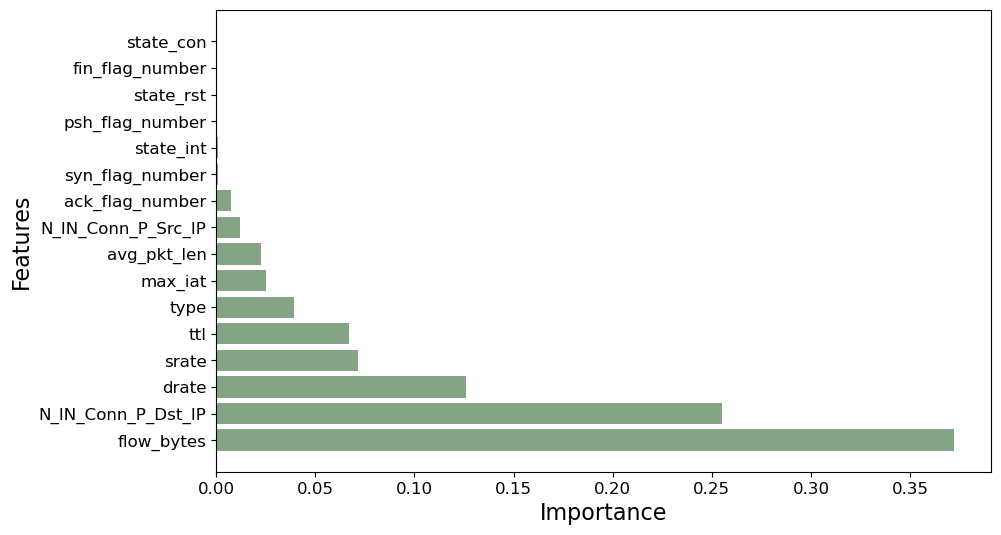

In [84]:
best_features.rename(columns={"N_IN_Conn_P_Src_IP": "N_IN_Conn_Src_IP", "N_IN_Conn_P_Dst_IP": "N_IN_Conn_Dst_IP"})
labels = best_features.columns

importances = list(rf.feature_importances_)
print(importances)
colors = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_list =[importances[i] for i in sorted_indices]
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('')
plt.barh(range(X.shape[1]), sorted_list, align="center",color=colors )
plt.yticks(range(X.shape[1]), labels[sorted_indices], fontsize=12)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
# Save the plot as a PNG file
plt.savefig('Importance.png', bbox_inches='tight')
plt.show()

# Save RF Detector

In [85]:
import pickle as pickle
filename = 'final_rf_model_dos_time.sav'
pickle.dump(rf, open(filename, 'wb'))

# Now predicting about separatly processes data

In [86]:
current_path = os.getcwd()

file1='dataset/Benign_Test_1.csv'
benign = pd.read_csv(file1)
file2='dataset/RSTFIN_Test.csv'
rst = pd.read_csv(file2)
file3='dataset/TCPFlood.csv'
tcp = pd.read_csv(file3)
file4='dataset/SYN_Test.csv'
syn = pd.read_csv(file4)
file5='dataset/UDPFlood_Test.csv'
udp = pd.read_csv(file5)
file6='dataset/UDPFrag_Test.csv'
udp_frag = pd.read_csv(file6)
file7='dataset/HTTPFlood_Test.csv'
http = pd.read_csv(file7)
file8='dataset/SlowLoris_Test.csv'
slow = pd.read_csv(file8)
file9='dataset/PUSHACK_Test.csv'
psh = pd.read_csv(file9)
file10='dataset/ACKFrag_Test.csv'
ack = pd.read_csv(file10)

benign['attack'] = 0
rst['attack'] = 1
tcp['attack'] = 1
syn['attack'] = 1
udp['attack'] = 1
ack['attack'] = 1
psh['attack'] = 1
udp_frag['attack'] = 1
http['attack'] = 1
slow['attack'] = 1

# Test Benign

In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

data = pd.concat([benign])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:", 1- sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.8791887125220459
Precision:  [1. 0.]
Recall:  [0.87918871 0.        ]
F1-score:  [0.93571093 0.        ]
Support:  [1134    0]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test SYN Flood

In [61]:
data = pd.concat([syn])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9963428207982191
Precision:  [0. 1.]
Recall:  [0.         0.99634282]
F1-score:  [0.         0.99816806]
Support:  [    0 12578]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TCP PUSH ACK

In [32]:
data = pd.concat([psh])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9996952961340697
Precision:  [0. 1.]
Recall:  [0.        0.9996953]
F1-score:  [0.         0.99984762]
Support:  [    0 26255]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TCP ACK Fragmentation

In [33]:
data = pd.concat([ack])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9877085162423178
Precision:  [0. 1.]
Recall:  [0.         0.98770852]
F1-score:  [0.         0.99381625]
Support:  [   0 1139]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test TCP DoS

In [34]:
data = pd.concat([tcp])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9991228880066476
Precision:  [0. 1.]
Recall:  [0.         0.99912289]
F1-score:  [0.         0.99956125]
Support:  [    0 43324]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test RST FIN Flood

In [35]:
data = pd.concat([rst])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9982426778242678
Precision:  [0. 1.]
Recall:  [0.         0.99824268]
F1-score:  [0.         0.99912057]
Support:  [    0 11950]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test UDP Flood

In [36]:
data = pd.concat([udp])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9950118947126084
Precision:  [0. 1.]
Recall:  [0.         0.99501189]
F1-score:  [0.         0.99749971]
Support:  [    0 13031]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test HTTP Flood

In [37]:
data = pd.concat([http])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.855526544821584
Precision:  [0. 1.]
Recall:  [0.         0.85552654]
F1-score:  [0.         0.92213884]
Support:  [   0 2298]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test UDP Frag

In [38]:
data = pd.concat([udp_frag])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9980988593155894
Precision:  [0. 1.]
Recall:  [0.         0.99809886]
F1-score:  [0.         0.99904853]
Support:  [  0 526]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test Slowloris

In [39]:
data = pd.concat([slow])
data['type'] = data['proto_type'].apply(lambda x: 0 if x > 6 else 1)
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.8722410865874364
Precision:  [0. 1.]
Recall:  [0.         0.87224109]
F1-score:  [0.         0.93176151]
Support:  [   0 4712]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
